In [1]:
# 🟢 STEP 2: Import Libraries
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [7]:
# 🟢 STEP 3: Load Data (Upload files if running standalone)
from google.colab import files
uploaded = files.upload()  # Upload all .npy files saved earlier
# After running this cell, a file picker will appear.
# Select and upload all the .npy files you need.



Saving lambda_r_t.npy to lambda_r_t (1).npy


In [8]:
uploaded = files.upload()

Saving mu_r_t.npy to mu_r_t.npy


In [9]:
uploaded = files.upload()

Saving mu_w_t.npy to mu_w_t.npy


In [10]:
uploaded = files.upload()

Saving lambda_f_t.npy to lambda_f_t.npy


In [11]:
uploaded = files.upload()

Saving R_RK.npy to R_RK.npy


In [12]:
uploaded = files.upload()

Saving W_RK.npy to W_RK.npy


In [13]:
uploaded = files.upload()

Saving F_RK.npy to F_RK.npy


In [21]:
lambda_r_t = np.load('lambda_r_t.npy')
mu_r_t     = np.load('mu_r_t.npy')
mu_w_t     = np.load('mu_w_t.npy')
lambda_f_t = np.load('lambda_f_t.npy')
R_RK       = np.load('R_RK.npy')
W_RK       = np.load('W_RK.npy')
F_RK       = np.load('F_RK.npy')


In [20]:
# F_RK.npy print the data

f_rk_data = np.load('F_RK.npy')
f_rk_data

array([0.        , 1.09008621, 2.44086466, ..., 0.19408021, 0.18384612,
       0.18130035])

In [22]:
 # 🟢 STEP 4: Define PINN Model for Control Functions
class ControlNN(nn.Module):
    def __init__(self):
        super(ControlNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 4)  # lambda_r, mu_r, mu_w, lambda_f
        )

    def forward(self, t):
        return self.net(t)


In [26]:
# 🟢 STEP 5: Physics-Informed Loss Function
def physics_loss(model, t):
    t = t.view(-1, 1)
    # t does not need gradients here as it's the input time points,
    # but the model output based on t does.
    # Removing t.requires_grad = True as it's not necessary for the inputs
    # unless you were performing operations on t itself that needed gradients.

    control = model(t)
    lam_r, mu_r, mu_w, lam_f = control[:, 0], control[:, 1], control[:, 2], control[:, 3]

    # Initialize lists to store the computed values
    R_values = [torch.tensor(100.0, dtype=torch.float32)]
    W_values = [torch.tensor(0.0, dtype=torch.float32)]
    F_values = [torch.tensor(0.0, dtype=torch.float32)]

    h = 1.0
    for i in range(1, len(t)):
        # Compute the next values without modifying the previous tensor in place
        next_R = R_values[-1] + h * (lam_r[i-1] - mu_r[i-1] * R_values[-1])
        next_W = W_values[-1] + h * (mu_r[i-1] * R_values[-1] - mu_w[i-1] * W_values[-1])
        next_F = F_values[-1] + h * (mu_w[i-1] * W_values[-1] - lam_f[i-1] * F_values[-1])

        # Append the new values to the lists
        R_values.append(next_R)
        W_values.append(next_W)
        F_values.append(next_F)

    # Convert the lists of tensors into single tensors
    R = torch.stack(R_values).view(-1, 1)
    W = torch.stack(W_values).view(-1, 1)
    F = torch.stack(F_values).view(-1, 1)

    # Target is the Runge-Kutta results
    R_target = torch.tensor(R_RK, dtype=torch.float32).view(-1, 1)
    W_target = torch.tensor(W_RK, dtype=torch.float32).view(-1, 1)
    F_target = torch.tensor(F_RK, dtype=torch.float32).view(-1, 1)

    loss = nn.MSELoss()(R, R_target) + nn.MSELoss()(W, W_target) + nn.MSELoss()(F, F_target)
    return loss

In [27]:
# 🟢 STEP 6: Train PINN
model = ControlNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1000
t_tensor = torch.linspace(0, len(lambda_r_t) - 1, len(lambda_r_t)).view(-1, 1)

losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = physics_loss(model, t_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")
    losses.append(loss.item())


Epoch 0, Loss: nan
Epoch 100, Loss: nan
Epoch 200, Loss: nan
Epoch 300, Loss: nan
Epoch 400, Loss: nan
Epoch 500, Loss: nan
Epoch 600, Loss: nan
Epoch 700, Loss: nan
Epoch 800, Loss: nan
Epoch 900, Loss: nan


In [28]:
# 🔁 STEP 1: Define Stable PINN Model with Output Constraints
class ControlNN(nn.Module):
    def __init__(self):
        super(ControlNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 4),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def forward(self, t):
        return self.net(t)

# 🔁 STEP 2: Stable Physics-Informed Loss Function
def physics_loss(model, t):
    t = t.view(-1, 1)
    t.requires_grad = True

    control = model(t)
    lam_r, mu_r, mu_w, lam_f = control[:, 0], control[:, 1], control[:, 2], control[:, 3]

    R = torch.zeros_like(t)
    W = torch.zeros_like(t)
    F = torch.zeros_like(t)
    R[0] = 100.0
    W[0] = 0.0
    F[0] = 0.0

    h = 1.0
    for i in range(1, len(t)):
        R[i] = R[i-1] + h * (lam_r[i-1] - mu_r[i-1] * R[i-1])
        W[i] = W[i-1] + h * (mu_r[i-1] * R[i-1] - mu_w[i-1] * W[i-1])
        F[i] = F[i-1] + h * (mu_w[i-1] * W[i-1] - lam_f[i-1] * F[i-1])

        # Prevent invalid values
        R[i] = torch.clamp(R[i], min=0.0)
        W[i] = torch.clamp(W[i], min=0.0)
        F[i] = torch.clamp(F[i], min=0.0)

    # Target is the Runge-Kutta results
    R_target = torch.tensor(R_RK, dtype=torch.float32).view(-1, 1)
    W_target = torch.tensor(W_RK, dtype=torch.float32).view(-1, 1)
    F_target = torch.tensor(F_RK, dtype=torch.float32).view(-1, 1)

    loss = nn.MSELoss()(R, R_target) + nn.MSELoss()(W, W_target) + nn.MSELoss()(F, F_target)
    return loss


In [31]:
# 🔁 STEP 2: Stable Physics-Informed Loss Function (Corrected for Autograd)
def physics_loss(model, t):
    t = t.view(-1, 1)
    # t does not need gradients here as it's the input time points,
    # but the model output based on t does.
    # Removing t.requires_grad = True as it's not necessary for the inputs
    # unless you were performing operations on t itself that needed gradients.
    # t.requires_grad = True # Removed as it's not needed for this calculation

    control = model(t)
    # Applying clamp or sigmoid to ensure positive control values, which might be necessary
    # depending on the physical meaning of the control parameters.
    # If the Sigmoid is already in the model (as in the second ControlNN definition),
    # you might not need clamping here, but it's good practice if the model output
    # isn't constrained. Let's assume the model has the Sigmoid layer.
    lam_r, mu_r, mu_w, lam_f = control[:, 0], control[:, 1], control[:, 2], control[:, 3]

    # Initialize lists to store the computed values - This avoids inplace operations on tensors
    R_values = [torch.tensor(100.0, dtype=torch.float32)]
    W_values = [torch.tensor(0.0, dtype=torch.float32)]
    F_values = [torch.tensor(0.0, dtype=torch.float32)]

    h = 1.0
    for i in range(1, len(t)):
        # Compute the next values without modifying the previous tensor in place
        # These operations create new tensors in each step, preserving the graph
        next_R = R_values[-1] + h * (lam_r[i-1] - mu_r[i-1] * R_values[-1])
        next_W = W_values[-1] + h * (mu_r[i-1] * R_values[-1] - mu_w[i-1] * W_values[-1])
        next_F = F_values[-1] + h * (mu_w[i-1] * W_values[-1] - lam_f[i-1] * F_values[-1])

        # Clamping the values after computation to ensure non-negativity.
        # This clamp is also an operation that respects the gradient graph.
        next_R = torch.clamp(next_R, min=0.0)
        next_W = torch.clamp(next_W, min=0.0)
        next_F = torch.clamp(next_F, min=0.0)

        # Append the new values to the lists
        R_values.append(next_R)
        W_values.append(next_W)
        F_values.append(next_F)


    # Convert the lists of tensors into single tensors
    # torch.stack is a differentiable operation
    R = torch.stack(R_values).view(-1, 1)
    W = torch.stack(W_values).view(-1, 1)
    F = torch.stack(F_values).view(-1, 1)

    # Target is the Runge-Kutta results
    R_target = torch.tensor(R_RK, dtype=torch.float32).view(-1, 1)
    W_target = torch.tensor(W_RK, dtype=torch.float32).view(-1, 1)
    F_target = torch.tensor(F_RK, dtype=torch.float32).view(-1, 1)

    # Calculate the loss
    loss = nn.MSELoss()(R, R_target) + nn.MSELoss()(W, W_target) + nn.MSELoss()(F, F_target)
    return loss

In [32]:
model = ControlNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 500
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = physics_loss(model, t_tensor)
    if torch.isnan(loss):
        print(f"Epoch {epoch}: Loss became nan, stopping early.")
        break
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")
    losses.append(loss.item())


Epoch 0, Loss: 41.57805
Epoch 100, Loss: 0.71800
Epoch 200, Loss: 0.59099
Epoch 300, Loss: 0.58146
Epoch 400, Loss: 0.57607


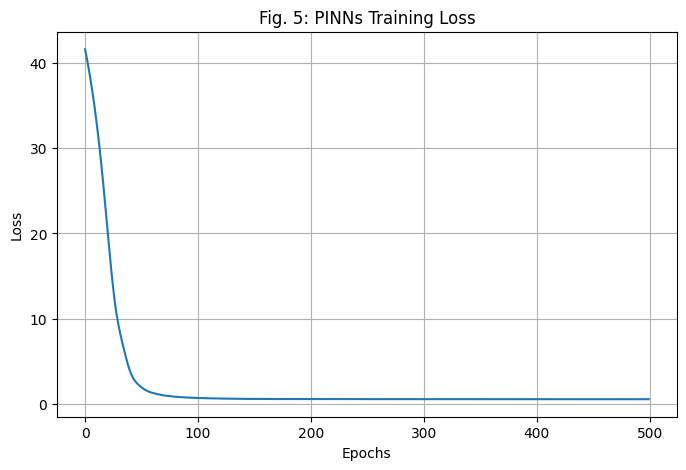

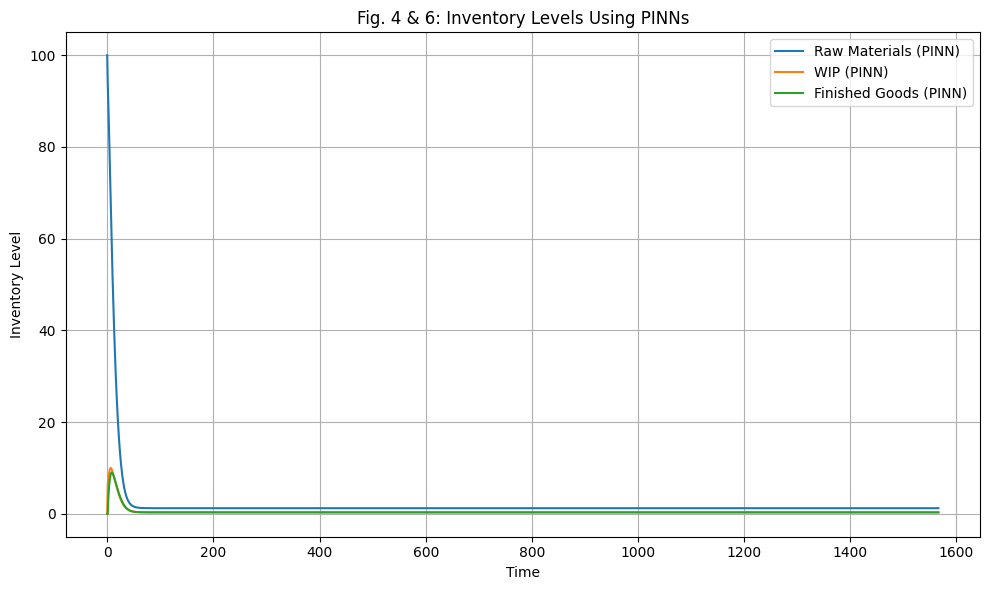

In [33]:
 # 🟢 STEP 7: Plot PINNs Loss Curve (Fig. 5)
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.title("Fig. 5: PINNs Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 🟢 STEP 8: Predict Inventory Using Trained PINN (Fig. 4 & 6)
t_tensor.requires_grad = False
predicted_controls = model(t_tensor).detach().numpy()
lambda_r_pred, mu_r_pred, mu_w_pred, lambda_f_pred = predicted_controls.T

# Simulate with PINN control values
R_pinn = np.zeros_like(lambda_r_pred)
W_pinn = np.zeros_like(lambda_r_pred)
F_pinn = np.zeros_like(lambda_r_pred)
R_pinn[0] = 100

for i in range(1, len(R_pinn)):
    R_pinn[i] = R_pinn[i-1] + (lambda_r_pred[i-1] - mu_r_pred[i-1] * R_pinn[i-1])
    W_pinn[i] = W_pinn[i-1] + (mu_r_pred[i-1] * R_pinn[i-1] - mu_w_pred[i-1] * W_pinn[i-1])
    F_pinn[i] = F_pinn[i-1] + (mu_w_pred[i-1] * W_pinn[i-1] - lambda_f_pred[i-1] * F_pinn[i-1])

# Plot Inventory Prediction (Fig. 4 & 6)
plt.figure(figsize=(10, 6))
plt.plot(R_pinn, label='Raw Materials (PINN)')
plt.plot(W_pinn, label='WIP (PINN)')
plt.plot(F_pinn, label='Finished Goods (PINN)')
plt.title("Fig. 4 & 6: Inventory Levels Using PINNs")
plt.xlabel("Time")
plt.ylabel("Inventory Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

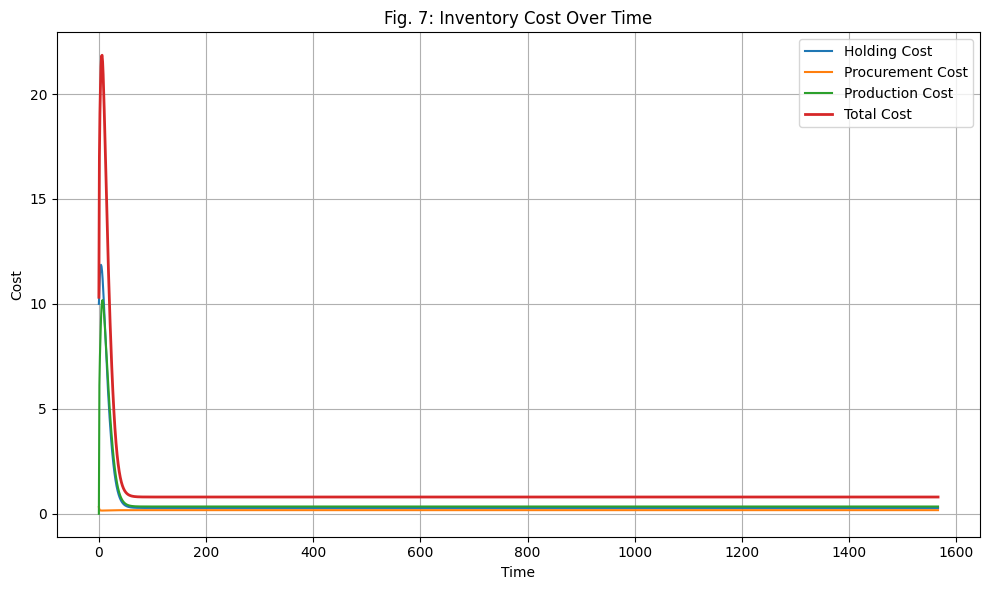

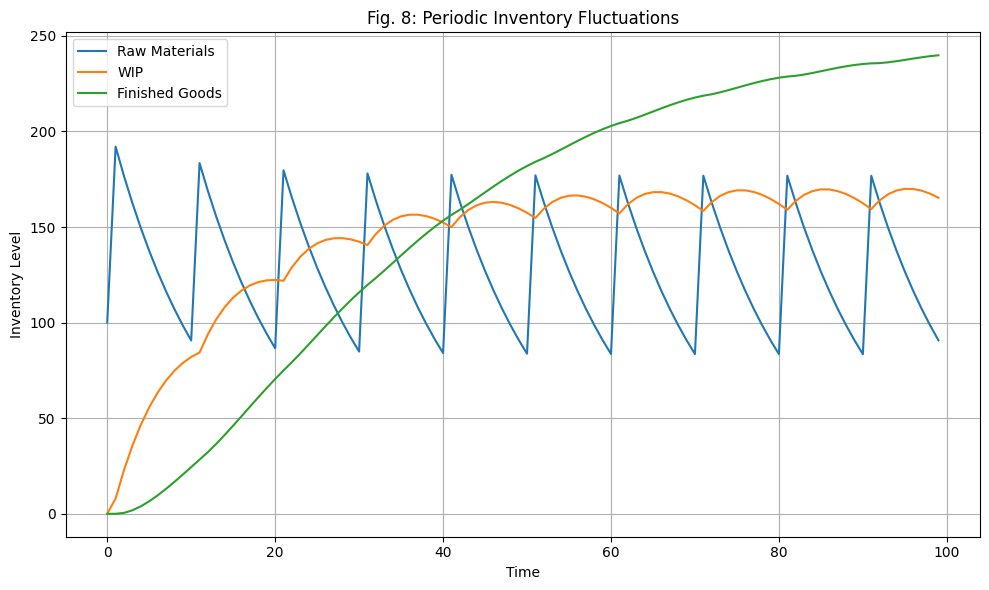

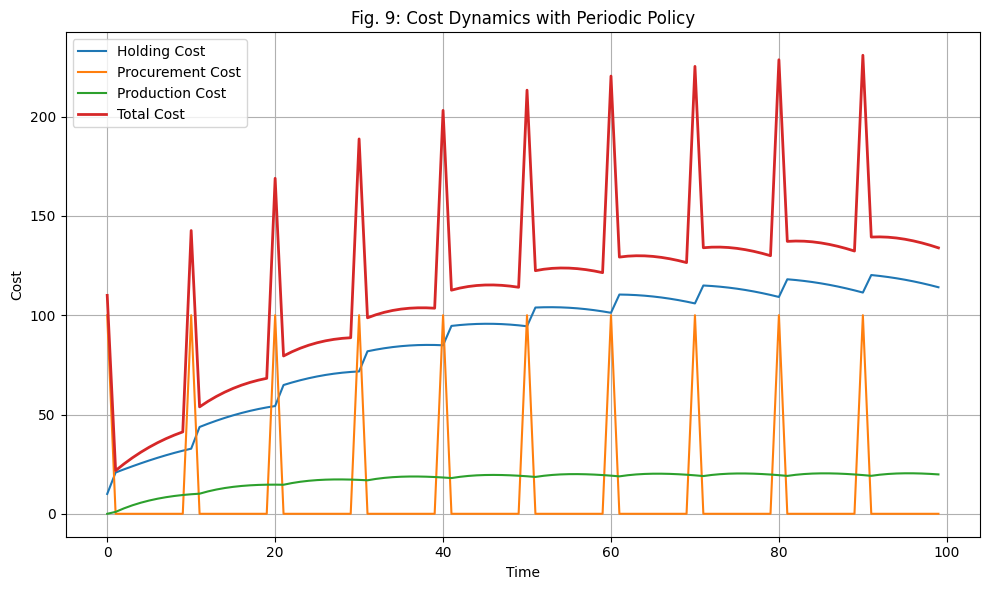

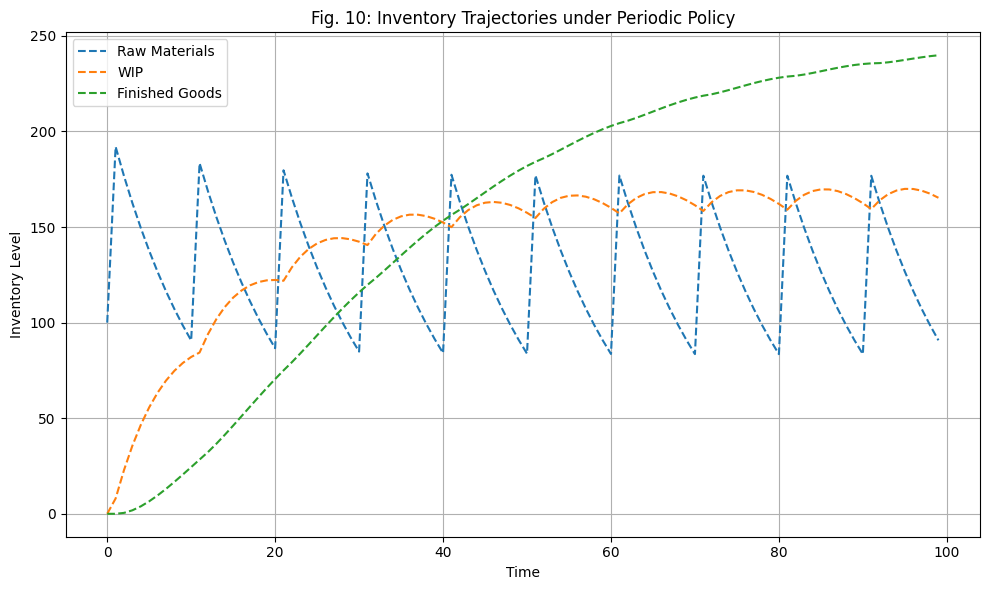

In [34]:
# 🔁 STEP 9: FIG. 7 - Compute and Plot Cost Over Time
hR, hW, hF = 0.1, 0.2, 0.3  # Holding costs per unit
cR = 1.0                    # Procurement cost per unit λ_r
cP = 2.0                    # Production cost per unit µ_w * W

holding_cost = hR * R_pinn + hW * W_pinn + hF * F_pinn
procurement_cost = cR * lambda_r_pred
production_cost = cP * mu_w_pred * W_pinn

total_cost = holding_cost + procurement_cost + production_cost

plt.figure(figsize=(10, 6))
plt.plot(holding_cost, label='Holding Cost')
plt.plot(procurement_cost, label='Procurement Cost')
plt.plot(production_cost, label='Production Cost')
plt.plot(total_cost, label='Total Cost', linewidth=2)
plt.title("Fig. 7: Inventory Cost Over Time")
plt.xlabel("Time")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 🔁 STEP 10: FIG. 8-10 — Periodic Replenishment Simulation
T_sim = 100
R_per, W_per, F_per = np.zeros(T_sim), np.zeros(T_sim), np.zeros(T_sim)
R_per[0] = 100

# Periodic Replenishment Policy
cycle_time = 10
pulse_duration = 1
lambda_r_periodic = np.array([
    100.0 if (t % cycle_time) < pulse_duration else 0.0
    for t in range(T_sim)
])
mu_r_fixed = 0.08
mu_w_fixed = 0.06
lambda_f_fixed = 0.04

# Simulate
for t in range(1, T_sim):
    R_per[t] = R_per[t-1] + (lambda_r_periodic[t-1] - mu_r_fixed * R_per[t-1])
    W_per[t] = W_per[t-1] + (mu_r_fixed * R_per[t-1] - mu_w_fixed * W_per[t-1])
    F_per[t] = F_per[t-1] + (mu_w_fixed * W_per[t-1] - lambda_f_fixed * F_per[t-1])

    # Prevent negative values
    R_per[t] = max(R_per[t], 0)
    W_per[t] = max(W_per[t], 0)
    F_per[t] = max(F_per[t], 0)

# 🔁 STEP 11: FIG. 8 - Periodic Inventory Fluctuation
plt.figure(figsize=(10, 6))
plt.plot(R_per, label="Raw Materials")
plt.plot(W_per, label="WIP")
plt.plot(F_per, label="Finished Goods")
plt.title("Fig. 8: Periodic Inventory Fluctuations")
plt.xlabel("Time")
plt.ylabel("Inventory Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔁 STEP 12: FIG. 9 - Cost Dynamics under Periodic Policy
holding_cost_per = hR * R_per + hW * W_per + hF * F_per
procurement_cost_per = cR * lambda_r_periodic
production_cost_per = cP * mu_w_fixed * W_per
total_cost_per = holding_cost_per + procurement_cost_per + production_cost_per

plt.figure(figsize=(10, 6))
plt.plot(holding_cost_per, label='Holding Cost')
plt.plot(procurement_cost_per, label='Procurement Cost')
plt.plot(production_cost_per, label='Production Cost')
plt.plot(total_cost_per, label='Total Cost', linewidth=2)
plt.title("Fig. 9: Cost Dynamics with Periodic Policy")
plt.xlabel("Time")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔁 STEP 13: FIG. 10 - Inventory Trajectories Over Time (Zoomed)
plt.figure(figsize=(10, 6))
plt.plot(R_per, label="Raw Materials", linestyle='--')
plt.plot(W_per, label="WIP", linestyle='--')
plt.plot(F_per, label="Finished Goods", linestyle='--')
plt.title("Fig. 10: Inventory Trajectories under Periodic Policy")
plt.xlabel("Time")
plt.ylabel("Inventory Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


| Variable           | Formula in Code                            | Meaning                            |
| ------------------ | ------------------------------------------ | ---------------------------------- |
| $\mu_w(t)$         | `mu_w_t = 0.04 + 0.01 * sin(0.1 * t)`      | Production rate WIP → FG           |
| $\lambda_f(t)$     | `lambda_f_t = 0.02 + 0.01 * cos(0.1 * t)`  | Dispatch rate FG → market          |
| $W(t)$             | `W_t = 100 + 30 * sin(0.1 * t + 0.5)`      | Inventory of items in production   |
| $\text{Demand}(t)$ | `demand_t = 50 + 30 * sin(0.07 * t + 1.0)` | External fluctuating market demand |


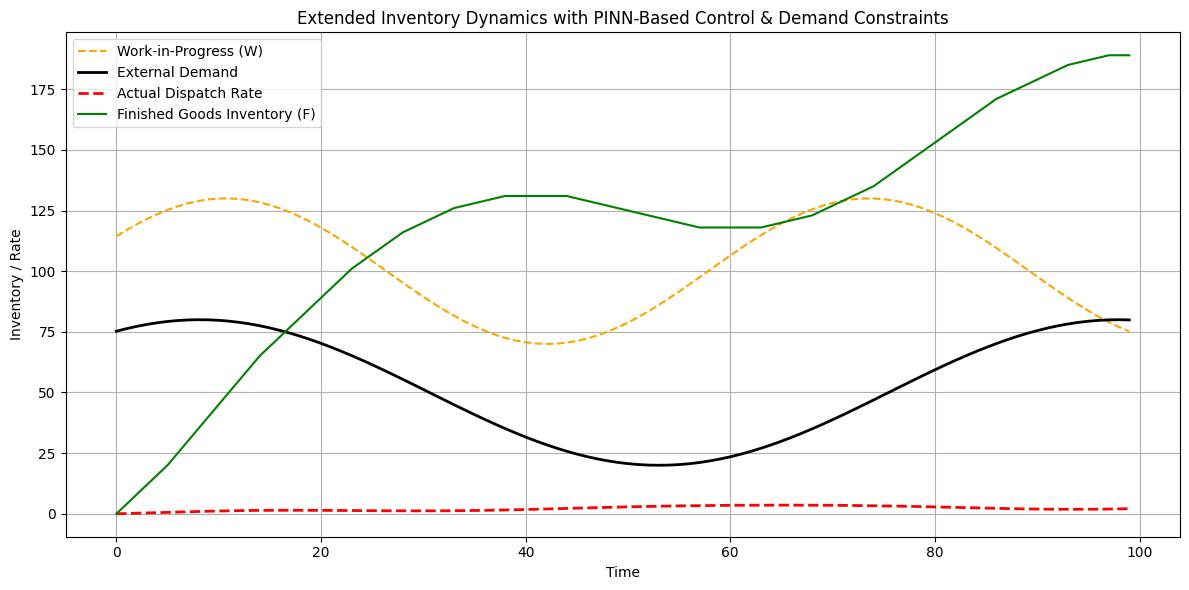

In [35]:
# ✅ STEP 1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt

# ✅ STEP 2: Define Time and Control Parameters
T = 100
time = np.arange(0, T, 1)

# Simulated PINN-like control functions
mu_w_t = 0.04 + 0.01 * np.sin(0.1 * time)           # WIP to FG conversion
lambda_f_t = 0.02 + 0.01 * np.cos(0.1 * time)       # Dispatch/sales rate
demand_t = 50 + 30 * np.sin(0.07 * time + 1.0)      # External demand

# Simulate Work-in-Progress W(t)
W_t = 100 + 30 * np.sin(0.1 * time + 0.5)

# ✅ STEP 3: Initialize Finished Goods Inventory F(t)
F_t = np.zeros_like(time)

# ✅ STEP 4: Simulate Inventory Dynamics with Demand-Constrained Dispatch
for t in range(1, T):
    dispatch = min(lambda_f_t[t-1] * F_t[t-1], demand_t[t-1])
    F_t[t] = F_t[t-1] + (mu_w_t[t-1] * W_t[t-1] - dispatch)
    F_t[t] = max(F_t[t], 0)  # Prevent negative inventory

# ✅ STEP 5: Recalculate Actual Dispatch for Plotting
dispatch_t = np.minimum(lambda_f_t * F_t, demand_t)

# ✅ STEP 6: Plot Results
plt.figure(figsize=(12, 6))
plt.plot(time, W_t, label="Work-in-Progress (W)", linestyle='--', color='orange')
plt.plot(time, demand_t, label="External Demand", color='black', linewidth=2)
plt.plot(time, dispatch_t, label="Actual Dispatch Rate", color='red', linestyle='--', linewidth=2)
plt.plot(time, F_t, label="Finished Goods Inventory (F)", color='green')
plt.title("Extended Inventory Dynamics with PINN-Based Control & Demand Constraints")
plt.xlabel("Time")
plt.ylabel("Inventory / Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
